In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
%matplotlib inline


In [4]:
# Load our data for the different analyses here -- may take awhile
norm_mrna_exp = pd.read_csv(open(
    "../data/intermediate/norm_mrna.txt",'r')
                            ,sep="\t")
can_mrna_exp = pd.read_csv(open(
    "../data/intermediate/cancer_mrna.txt",'r')
                           ,sep="\t")
fld_chng_mrna = pd.read_csv(open(
    "../data/output/cancer_fold_change_pivot.txt",'r'),
                           sep="\t")
matched_fld_chng = pd.read_csv(open(
    "../data/intermediate/merged_protein_mrna.txt",'r'),
                              sep="\t")
pearson_prot_mrna = pd.read_csv(open(
    "../data/output/pearsonr_prot_mrna.txt",'r'),
                               sep="\t")
corr_df = pd.read_csv(open(
    '../data/output/corr_data.txt','r'),sep="\t")

# Supplemental figures 

## Figure 1 : Tumor-matched normal and tumor sample expression distributions 
mRNA expression distributions for tumor-matched normal and tumor samples.  Distributions are similar suggesting no batch effect or temporal confounder.  This does not illustrate changes of a singluar genes expression between the two states, rather summary information of expression.

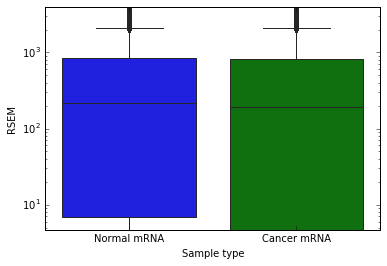

In [5]:
norm_melt = pd.melt(norm_mrna_exp,id_vars=['gene_id'])
norm_melt['type'] = 'Normal mRNA'
cancer_melt = pd.melt(can_mrna_exp,id_vars=['gene_id'])
cancer_melt['type'] = 'Cancer mRNA'
combined_melt = norm_melt.append(cancer_melt)

ax = sns.boxplot(x="type", y="value", data=combined_melt)
ax.set_yscale('log')
plt.ylim(-10, 4000)
plt.xlabel("Sample type")
plt.ylabel("RSEM");

## Figure 2: mRNA log2 fold change from normal median to cancer
mRNA log2 fold change distributions illustrate classes of genes within patients that have high degrees of alteration.  In this instance we can now identify genes with large log2 fold change differences from cancer to healthy states.

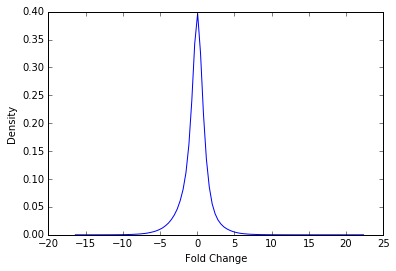

In [6]:
fld_chng_melt = pd.melt(fld_chng_mrna,id_vars=['gene'])
sns.distplot(fld_chng_melt['value'].dropna(), hist=False, rug=False)
plt.xlabel("Fold Change")
plt.ylabel("Density");

## Figure 3: Patient matched mRNA and protein fold change distributions
mRNA and protein fold change distributions illustrating similarity in a similar distribution with a mean around 0, however tails and quantiles are different.

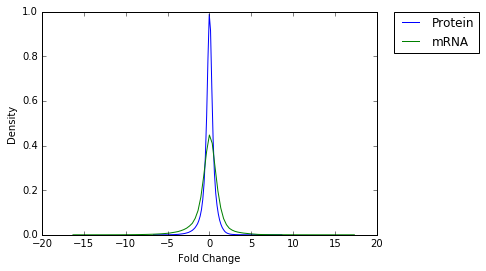

In [7]:
# calculate z score as above:
# value minus the mean of the vector over the S.D.
def calculate_z(val,val_mean,val_sd):
    num   = val - val_mean
    denom = val_sd
    # make sure the denominator is not 0
    if denom != 0:
        return num/denom
    else:
        return np.nan

# Calculate mean value and SD for mrna/protein
mean_prot = np.mean(matched_fld_chng['prot'])
mean_mrna = np.mean(matched_fld_chng['mrna'])
sd_prot   = np.std(matched_fld_chng['prot'])
sd_mrna   = np.std(matched_fld_chng['mrna'])

matched_fld_chng['prot_z'] = matched_fld_chng['prot'].apply(
    lambda x: calculate_z(x,mean_prot,sd_prot))
matched_fld_chng['mrna_z'] = matched_fld_chng['mrna'].apply(
    lambda x: calculate_z(x,mean_mrna,sd_mrna))
sns.distplot(matched_fld_chng['prot'].dropna(), 
             hist=False, rug=False,label='Protein')
sns.distplot(matched_fld_chng['mrna'].dropna(), 
             hist=False, rug=False,label='mRNA')
plt.xlabel('Fold Change')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Figure 4: Patient matched mRNA and protein fold change distributions after normalization
mRNA and protein fold change distributions after z-score normalization show same distributions.

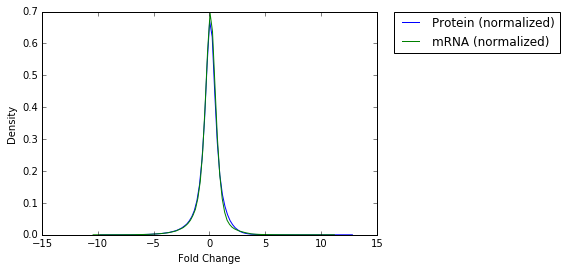

In [8]:
sns.distplot(matched_fld_chng['prot_z'].dropna(), 
             hist=False, rug=False,label='Protein (normalized)')
sns.distplot(matched_fld_chng['mrna_z'].dropna(), 
             hist=False, rug=False,label='mRNA (normalized)')
plt.xlabel('Fold Change')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Figure 5: Spearman correlation p value distribution between mRNA and Protein fold changes
Spearman correlation $-log_2$ p values were calculated between samples' mRNA and protein fold-change values.  

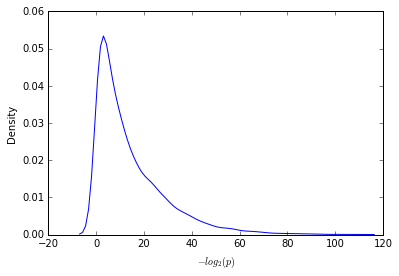

In [29]:
sns.distplot(-pearson_prot_mrna['pval'].dropna().apply(
    math.log2), hist=False, rug=False)
plt.xlabel('$-log_2(p)$')
plt.ylabel('Density');

## Figure 6: Correlation coefficient distribution
Overall correlation coefficient distributions between genomic features emphasizes the decoupling of mRNA and CNV from overall protein production in the TCGA breast cancer samples.

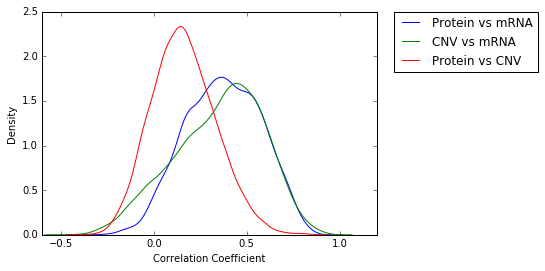

In [10]:
sns.distplot(corr_df['prot_v_mrna'].dropna(), 
             hist=False, rug=False,label='Protein vs mRNA')
sns.distplot(corr_df['cnv_v_mrna'].dropna(), 
             hist=False, rug=False,label='CNV vs mRNA')
sns.distplot(corr_df['prot_v_cnv'].dropna(), 
             hist=False, rug=False,label='Protein vs CNV')
plt.xlabel('Spearman Correlation Coefficient')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Figure 7: Correlation coefficient cutoff


Scatter plot of correlation threshold cut offs and subsequent member counts.  The red, dotted line indicates cutoff used for BDSG identification for the study.

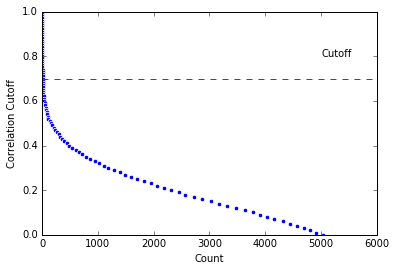

In [32]:
def count_genes(corr, corr_df):
    return corr_df['symbol'][(corr_df['prot_v_mrna'] > corr) & 
                      (corr_df['cnv_v_mrna'] > corr) & 
                      (corr_df['prot_v_cnv'] > corr)].shape[0]
    
corrs = np.sort(np.arange(0, 1, 0.01))[::-1]
res = pd.DataFrame(
    [{'Correlation Cutoff':corr, 
      'Count':count_genes(corr, corr_df)} 
     for corr in corrs])

ax = sns.scatterplot(x='Count', y='Correlation Cutoff',data=res)
ax.invert_xaxis()
ax.axes.set_ylim(0,1)
ax.axes.set_xlim(0,6000)
ax.axes.axhline(y=0.7, ls='--', color='red')
ax.axes.text(5000, .80, 'Cutoff');

## Figure 8 QQ plot of mRNA vs protein fold change correlations

QQ plot illustrating tailed nature of the distribution of correlational scores.  A D'Agostino's K-squared test rejected the null hypothesis that the data was Gaussian ($p < 0.005$).  This indicates the data is non-normal, with a marginally lighter left tail and heavier right tail.



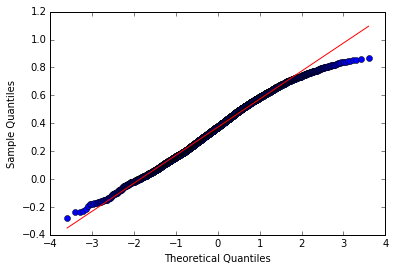

In [35]:
q = 0.05
vals = np.sort(corr_df['prot_v_mrna'].dropna().values.flatten())
    
from statsmodels.graphics.gofplots import qqplot
qqplot(vals, line='s');

# Supplemental Tables

## Table 1 Correlation cutoff and membership counts
Correlation cutoffs and associated membership counts.  These are gene symbols where all of their correlational values (protein vs mRNA, mRNA vs CNV, and protein vs CNV) are above the given cutoff.

In [31]:


pd.set_option('display.max_rows', None)
print(res.to_string(index=False))


Correlation_Cutoff  Count
              0.99      0
              0.98      0
              0.97      0
              0.96      0
              0.95      0
              0.94      0
              0.93      0
              0.92      0
              0.91      0
              0.90      0
              0.89      0
              0.88      0
              0.87      0
              0.86      0
              0.85      0
              0.84      1
              0.83      1
              0.82      2
              0.81      2
              0.80      2
              0.79      3
              0.78      4
              0.77      4
              0.76      5
              0.75      6
              0.74      8
              0.73      8
              0.72     10
              0.71     10
              0.70     12
              0.69     14
              0.68     16
              0.67     18
              0.66     21
              0.65     22
              0.64     24
              0.63     25
            